In [1]:
import inr_sos
# no load
from inr_sos import DATA_DIR, load_mat, clear_cache, inspect_mat_fileheader, load_ic_batch, load_L_matrix
# no load
from inr_sos.MLP.models import ReluMLP, SIRENMLP, FourierMLP
# no load
from inr_sos.utils.dataset import RayDataset

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

import logging
import sys
import wandb

logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = {
    # --- Experiment Metadata (For WandB) ---
    "project_name": "INR-SoS-Recon",       
    "dataset_name": "Inverse_Crime",
    
    # --- Sample index ---
    "sample_idx":8,

    # --- Model ----
    "hidden_features" : 256,
    "in_features" : 2,
    "hidden_layers" : 3,
    
    # --- Optimization ---
    'lr': 1e-4,               # Learning Rate (1e-4 is standard for SIREN)
    'epochs': 2000,           # Number of optimization iterations
    'log_interval': 100,      # Print loss every N steps
    'batch_size' : 2048,
    
    # --- Physics Scaling ---
    'time_scale': 1e6,       # Multiplier for Loss (Seconds -> Microseconds)
                             # Crucial for gradient stability!

    "omega": 20.0,
    "scale": 0.7,
    
    # --- Regularization ---
    'reg_weight': 0.00,       # Weight for L2 regularization on network output
                             # Prevents the unobserved regions from exploding
    'tv_weight' : 0.00       # total variation regularization
}

def setup_wandb_run(config):
    """Helper to initialize wandb with rich filtering metadata."""
    run_name = f"{config['model_type']}-Sample_{config['sample_idx']}"
    
    wandb.init(
        project=config['project_name'],
        group=config['experiment_group'], # Groups runs together in the UI
        name=run_name,
        tags=[config['model_type'], config['dataset_name']],
        config=config,
        reinit=True
    )

# Exploring the L-matrix (Physics wave)

In [24]:
L_matrix_exploartion = inr_sos.inspect_mat_fileheader(DATA_DIR + "/DL-based-SoS/forward_model_lr/L.mat") # strored in Compressed Sparse Column (CSC) format


[HDF5 Format Detected]
  Key: 'L' | Type: Group
  Key: 'L/data' | Shape: (74580122,) | Type: Dataset
  Key: 'L/ir' | Shape: (74580122,) | Type: Dataset
  Key: 'L/jc' | Shape: (4097,) | Type: Dataset


In [2]:
inverse_crime_data_exploartion = inr_sos.inspect_mat_fileheader(DATA_DIR + "/DL-based-SoS/train-VS-8pairs-IC-081225.mat")


[HDF5 Format Detected]
  Key: 'A' | Shape: (4096, 131072) | Type: Dataset
  Key: 'imgs_gt' | Shape: (10000, 64, 64) | Type: Dataset
  Key: 'measmnts' | Shape: (10000, 131072) | Type: Dataset
  Key: 'nanidx' | Shape: (10000, 131072) | Type: Dataset


In [3]:
128*128*8

131072

In [32]:
grid_params = inr_sos.inspect_mat_fileheader(DATA_DIR + "/DL-based-SoS/forward_model_lr/grid_parameters.mat")


[Scipy Format Detected (v7.2 or older)]
  Key: 'xDT' | Shape: (1, 128)
  Key: 'xax_sos' | Shape: (1, 64)
  Key: 'xdt' | Shape: (128, 128)
  Key: 'zDT' | Shape: (1, 128)
  Key: 'zax_sos' | Shape: (1, 64)
  Key: 'zdt' | Shape: (128, 128)


In [3]:
L_mat_path = DATA_DIR / "DL-based-SoS/forward_model_lr/L.mat"
L_matrix = load_mat(L_mat_path)['L']
L_matrix.shape

Detected v7.3 MATLAB file: L.mat
  -> Reconstructing sparse matrix: /L


(131072, 4096)

Analyzing 8 Transmissions (Frames)...


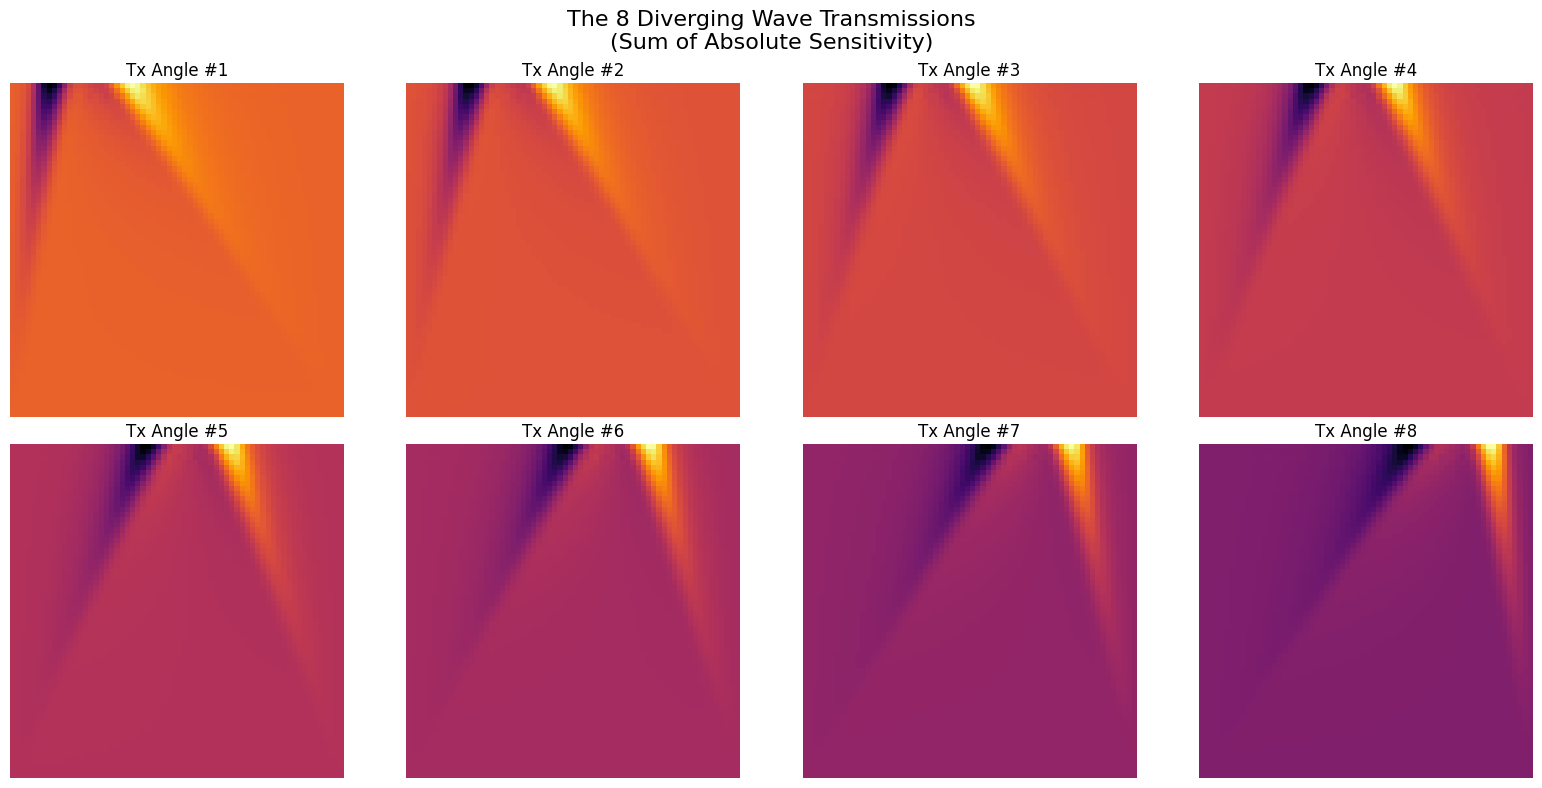

In [4]:
import matplotlib.pyplot as plt
import numpy as np
n_pixels_recon = 64 * 64   # 4096
n_pixels_data = 128 * 128  # 16384 (Size of one "Frame")
n_angles = 8

print(f"Analyzing {n_angles} Transmissions (Frames)...")

# 3. VISUALIZE THE 8 ANGLES
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(n_angles):
    # Calculate start and end row for this angle
    start_row = i * n_pixels_data
    end_row = (i + 1) * n_pixels_data
    
    # Extract the block of 16,384 rows for this angle
    # This represents ALL rays fired during Transmission #i
    L_chunk = L_matrix[start_row:end_row, :]
    
    # "Collapse" the rays to see the overall coverage
    # We sum along the rows (axis 0) to see which pixels were hit the most
    coverage_map_flat = L_chunk.sum(axis=0) # Result shape: (1, 4096)
    
    # Reshape to Image (Remember: Order F)
    coverage_img = np.array(coverage_map_flat).reshape((64, 64), order='F')
    
    # Plot
    im = axes[i].imshow(coverage_img, cmap='inferno')
    axes[i].set_title(f"Tx Angle #{i+1}")
    axes[i].axis('off')

plt.suptitle("The 8 Diverging Wave Transmissions\n(Sum of Absolute Sensitivity)", fontsize=16)
plt.tight_layout()
plt.show()

# Exploring the grid parameter, and mask data

## grid parameter

In [29]:
grid_parameters_matrix = load_mat(DATA_DIR + "/DL-based-SoS/forward_model_lr/grid_parameters.mat")

In [30]:
grid_parameters_matrix.keys()

dict_keys(['__header__', '__version__', '__globals__', 'xDT', 'xax_sos', 'xdt', 'zDT', 'zax_sos', 'zdt'])

In [31]:
print(
grid_parameters_matrix["xDT"].shape,
grid_parameters_matrix["xax_sos"].shape,
grid_parameters_matrix["xdt"].shape,
grid_parameters_matrix["zDT"].shape,
grid_parameters_matrix["zax_sos"].shape,
grid_parameters_matrix["zdt"].shape, sep="\n")

(1, 128)
(1, 64)
(128, 128)
(1, 128)
(1, 64)
(128, 128)


In [44]:
grid_parameters_matrix['zax_sos']

array([[0.0003, 0.0009, 0.0015, 0.0021, 0.0027, 0.0033, 0.0039, 0.0045,
        0.0051, 0.0057, 0.0063, 0.0069, 0.0075, 0.0081, 0.0087, 0.0093,
        0.0099, 0.0105, 0.0111, 0.0117, 0.0123, 0.0129, 0.0135, 0.0141,
        0.0147, 0.0153, 0.0159, 0.0165, 0.0171, 0.0177, 0.0183, 0.0189,
        0.0195, 0.0201, 0.0207, 0.0213, 0.0219, 0.0225, 0.0231, 0.0237,
        0.0243, 0.0249, 0.0255, 0.0261, 0.0267, 0.0273, 0.0279, 0.0285,
        0.0291, 0.0297, 0.0303, 0.0309, 0.0315, 0.0321, 0.0327, 0.0333,
        0.0339, 0.0345, 0.0351, 0.0357, 0.0363, 0.0369, 0.0375, 0.0381]])

In [47]:
grid_parameters_matrix['xax_sos']

array([[-0.0189, -0.0183, -0.0177, -0.0171, -0.0165, -0.0159, -0.0153,
        -0.0147, -0.0141, -0.0135, -0.0129, -0.0123, -0.0117, -0.0111,
        -0.0105, -0.0099, -0.0093, -0.0087, -0.0081, -0.0075, -0.0069,
        -0.0063, -0.0057, -0.0051, -0.0045, -0.0039, -0.0033, -0.0027,
        -0.0021, -0.0015, -0.0009, -0.0003,  0.0003,  0.0009,  0.0015,
         0.0021,  0.0027,  0.0033,  0.0039,  0.0045,  0.0051,  0.0057,
         0.0063,  0.0069,  0.0075,  0.0081,  0.0087,  0.0093,  0.0099,
         0.0105,  0.0111,  0.0117,  0.0123,  0.0129,  0.0135,  0.0141,
         0.0147,  0.0153,  0.0159,  0.0165,  0.0171,  0.0177,  0.0183,
         0.0189]])

## mask data

In [9]:
mask_vector = load_mat(DATA_DIR / "DL-based-SoS/forward_model_lr/mask.mat")['mask']

Detected v7.3 MATLAB file: mask.mat


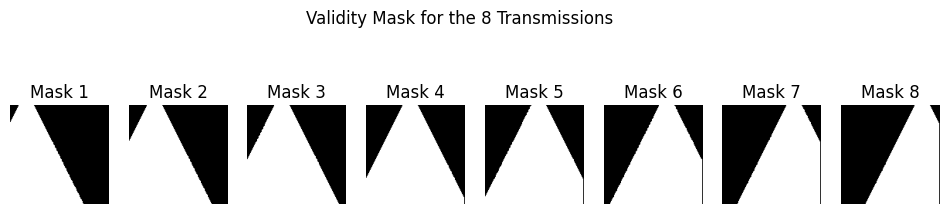

In [10]:
# Assume mask is loaded as 'mask_vector' shape (131072, 1)
# Reshape into (128, 128, 8)
# We use order='F' because it comes from MATLAB
mask_matrix = mask_vector.reshape((128, 128, 8), order='F')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(mask_matrix[:, :, i], cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')
plt.suptitle("Validity Mask for the 8 Transmissions")
plt.show()

# exploring K-wave data

In [2]:
test = inspect_mat_fileheader(DATA_DIR / "DL-based-SoS/train-VS-8pairs-IC-081225.mat")


[HDF5 Format Detected]
  Key: 'A' | Shape: (4096, 131072) | Type: Dataset
  Key: 'imgs_gt' | Shape: (10000, 64, 64) | Type: Dataset
  Key: 'measmnts' | Shape: (10000, 131072) | Type: Dataset
  Key: 'nanidx' | Shape: (10000, 131072) | Type: Dataset


Loading L Matrix...
L Matrix Shape: (131072, 4096)
Loading Sample #0...
Mismatch Error (MAE): 7.306892e-09


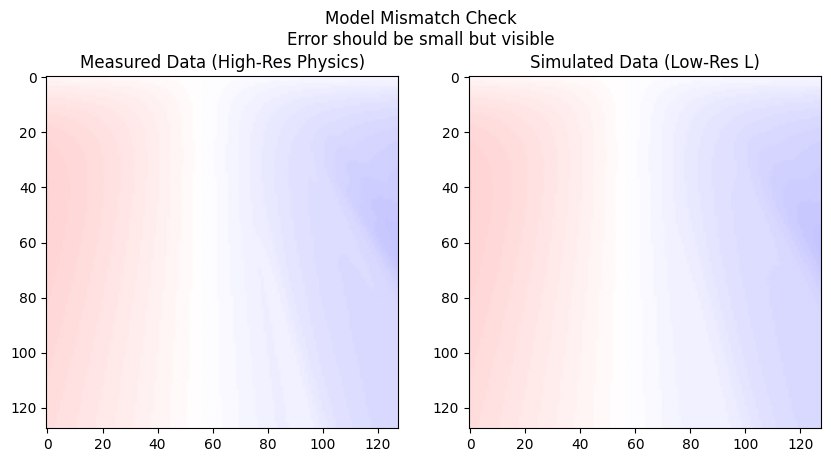

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 1. LOAD MATRIX (Just once)
print("Loading L Matrix...")
L_matrix = load_L_matrix(DATA_DIR / "DL-based-SoS/train-VS-8pairs-IC-081225.mat")
print(f"L Matrix Shape: {L_matrix.shape}") # Should be (131072, 4096)

# 2. LOAD SAMPLE #0
print("Loading Sample #0...")
s_gt, d_meas, mask = load_ic_batch(DATA_DIR / "DL-based-SoS/train-VS-8pairs-IC-081225.mat", idx=100)

# 3. SIMULATE (Model Mismatch Check)
# d_pred = L * s
d_pred = L_matrix.dot(s_gt)

# 4. ERROR ANALYSIS
# Only check valid regions
valid_idx = (mask == 1)
diff = (d_pred - d_meas) * mask
mae = np.mean(np.abs(diff[valid_idx]))

print(f"Mismatch Error (MAE): {mae:.6e}")
# Expectation: Small error (approx 1e-4 or 1e-5), but NOT zero.

# 5. VISUALIZE
# Reshape for plotting (Angle #4)
frame_len = 128*128
start = 3 * frame_len
end = 4 * frame_len

img_pred = d_pred[start:end].reshape((128, 128), order='F')
img_meas = d_meas[start:end].reshape((128, 128), order='F')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_meas, cmap='seismic', vmin=-1e-5, vmax=1e-5)
plt.title("Measured Data (High-Res Physics)")

plt.subplot(1, 2, 2)
plt.imshow(img_pred, cmap='seismic', vmin=-1e-5, vmax=1e-5)
plt.title("Simulated Data (Low-Res L)")

plt.suptitle(f"Model Mismatch Check\nError should be small but visible")
plt.show()

# Reconstruting Inverse Crime data

### Load dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_results(result_dict, sample, grid_shape=(64, 64), title="Reconstruction"):
    """
    Visualizes the reconstruction results, comparing GT vs Prediction.
    
    Args:
        result_dict (dict): Output from the reconstruct_sos function.
                            Must contain keys: 's_phys', 'loss_history'.
        sample (dict): The data sample (containing 's_gt_raw').
        grid_shape (tuple): The shape to reshape the 1D arrays (usually 64x64).
        title (str): Title for the figure.
    """
    
    # 1. Extract Data & Convert to Numpy
    # Ground Truth (Raw Slowness)
    s_gt = sample['s_gt_raw'].view(grid_shape).detach().cpu().numpy()
    
    # Reconstruction (Physical Slowness)
    s_rec = result_dict['s_phys'].view(grid_shape).detach().cpu().numpy()
    
    # Loss History
    loss_hist = result_dict['loss_history']
    
    # 2. Convert Slowness (s/m) -> Speed of Sound (m/s)
    # v = 1 / s
    v_gt = 1.0 / (s_gt + 1e-8)
    v_rec = 1.0 / (s_rec + 1e-8)
    
    # 3. Compute Absolute Error (in m/s)
    error_map = np.abs(v_gt - v_rec)
    mae = np.mean(error_map)
    
    # 4. Create Plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"{title} | MAE: {mae:.2f} m/s", fontsize=16)
    
    # Plot A: Ground Truth
    im0 = axes[0].imshow(v_gt, cmap='jet', vmin=1400, vmax=1600)
    axes[0].set_title("Ground Truth (m/s)")
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Plot B: Reconstruction
    im1 = axes[1].imshow(v_rec, cmap='jet', vmin=1400, vmax=1600)
    axes[1].set_title("Reconstruction (m/s)")
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot C: Error Map
    # Use 'hot' or 'inferno' to highlight errors. 
    im2 = axes[2].imshow(error_map, cmap='hot', vmin=0, vmax=50) 
    axes[2].set_title("Abs. Error (m/s)")
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    # Plot D: Loss Curve
    axes[3].plot(loss_hist, label='Total Loss', color='blue')
    axes[3].set_title("Optimization Loss")
    axes[3].set_xlabel("Iterations")
    axes[3].set_ylabel("Loss (Scaled)")
    axes[3].set_yscale('log') # Log scale is usually better for convergence plots
    axes[3].grid(True, which="both", ls="-", alpha=0.5)
    
    plt.tight_layout()
    plt.show()


def compare_reconstructions(v_gt, reconstructions, title, sample_idx=0):
    """
    Compare multiple reconstructions against Ground Truth.
    
    Args:
        v_gt: Ground truth SoS in m/s (64, 64)
        reconstructions: dict of {name: v_pred} where v_pred is (64, 64) in m/s
        sample_idx: for title display
    """
    
    # --- Metrics ---
    def compute_rmse(pred, gt):
        return np.sqrt(np.mean((pred - gt) ** 2))
    
    def compute_mae(pred, gt):
        return np.mean(np.abs(pred - gt))
    
    def compute_cnr(pred, gt, threshold_percentile=25):
        threshold = np.percentile(gt, threshold_percentile)
        inc_mask = gt < threshold
        bg_mask  = gt >= threshold
        if inc_mask.sum() == 0 or bg_mask.sum() == 0:
            return 0.0
        mean_inc = pred[inc_mask].mean()
        mean_bg  = pred[bg_mask].mean()
        var_inc  = pred[inc_mask].var()
        var_bg   = pred[bg_mask].var()
        return np.abs(mean_inc - mean_bg) / (np.sqrt(var_inc + var_bg) + 1e-12)
    
    n_methods = len(reconstructions)
    names = list(reconstructions.keys())
    preds = list(reconstructions.values())
    
    # Compute metrics
    metrics = {}
    for name, v_pred in reconstructions.items():
        metrics[name] = {
            'rmse': compute_rmse(v_pred, v_gt),
            'mae':  compute_mae(v_pred, v_gt),
            'cnr':  compute_cnr(v_pred, v_gt)
        }
    
    # Print table
    logging.info(f"\n{'='*70}")
    logging.info(f"  Reconstruction Comparison |  {title} | Sample {sample_idx}")
    logging.info(f"{'='*70}")
    logging.info(f"  {'Method':<25} {'RMSE (m/s)':<15} {'MAE (m/s)':<15} {'CNR':<10}")
    logging.info(f"  {'-'*60}")
    for name, m in metrics.items():
        logging.info(f"  {name:<25} {m['rmse']:<15.2f} {m['mae']:<15.2f} {m['cnr']:<10.2f}")
    cnr_gt = compute_cnr(v_gt, v_gt)
    logging.info(f"  {'GT (reference)':<25} {'0.00':<15} {'0.00':<15} {cnr_gt:<10.2f}")
    logging.info(f"{'='*70}")
    
    # --- Plot ---
    fig, axes = plt.subplots(2, n_methods + 1, figsize=(5 * (n_methods + 1), 10))
    fig.suptitle(f"Reconstruction Comparison | {title} | Sample {sample_idx}", fontsize=16)
    
    vmin, vmax = 1400, 1600
    err_vmax = max(compute_mae(p, v_gt) * 3 for p in preds)
    err_vmax = min(max(err_vmax, 10), 50)
    
    # Row 1: GT + Reconstructions
    im0 = axes[0, 0].imshow(v_gt, cmap='jet', vmin=vmin, vmax=vmax)
    axes[0, 0].set_title("Ground Truth")
    axes[0, 0].axis('off')
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    for i, name in enumerate(names):
        m = metrics[name]
        im = axes[0, i+1].imshow(preds[i], cmap='jet', vmin=vmin, vmax=vmax)
        axes[0, i+1].set_title(f"{name}\nRMSE:{m['rmse']:.2f} | MAE:{m['mae']:.2f} | CNR:{m['cnr']:.2f}")
        axes[0, i+1].axis('off')
        plt.colorbar(im, ax=axes[0, i+1], fraction=0.046, pad=0.04)
    
    # Row 2: Empty under GT + Error Maps
    axes[1, 0].axis('off')
    
    for i, name in enumerate(names):
        err = np.abs(v_gt - preds[i])
        im = axes[1, i+1].imshow(err, cmap='hot', vmin=0, vmax=err_vmax)
        axes[1, i+1].set_title(f"{name} Error\nMax: {err.max():.1f} m/s")
        axes[1, i+1].axis('off')
        plt.colorbar(im, ax=axes[1, i+1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    return metrics

def total_variation_loss(img, weight):
    # img shape: (Batch, 4096) -> reshape to (Batch, 1, 64, 64)
    bs = img.shape[0]
    img_2d = img.view(bs, 1, 64, 64)
    
    # Calculate gradients
    diff_h = torch.abs(img_2d[:, :, 1:, :] - img_2d[:, :, :-1, :])
    diff_w = torch.abs(img_2d[:, :, :, 1:] - img_2d[:, :, :, :-1])
    
    tv = diff_h.sum() + diff_w.sum()
    return weight * (tv / (64*64))

In [3]:
from inr_sos.utils.dataset import USDataset
import torch

inverse_data_file = DATA_DIR + "/DL-based-SoS/train-VS-8pairs-IC-081225.mat"
param_grid_file =  DATA_DIR  + "/DL-based-SoS/forward_model_lr/grid_parameters.mat"
analytical_data = inr_sos.load_mat(DATA_DIR + "/DL-based-SoS/train_IC_10k_l2rec_l1rec_imcon.mat")

# 1. Init Dataset
print("Initializing Dataset...")
dataset = USDataset(inverse_data_file, param_grid_file)
l_matrix = dataset.L_matrix 

# 2. Get One Sample
sample = dataset[0]
coords = sample['coords']
s_gt = sample['s_gt_raw']
d_meas = sample['d_meas']
mask = sample['mask']

print(f"\n--- Shape Verification ---")
print(f"Inputs (x,z):  {coords.shape}  (Expected: 4096, 2)")
print(f"Target (s):    {s_gt.shape}    (Expected: 4096, 1)")
print(f"Data (d):      {d_meas.shape}  (Expected: 131072, 1)")
print(f"Mask:          {mask.shape}    (Expected: 131072, 1)")

# 3. Verify Physics Compatibility (L * s = d)
print(f"L Matrix:      {l_matrix.shape}  (Expected: 131072, 4096)")

print("\n--- Tensor Math Check ---")
# d_pred = L @ s
d_pred = torch.matmul(l_matrix, s_gt)
print(f"Prediction shape: {d_pred.shape}")

# Calculate Error (Should be ~1e-9 like before)
diff = (d_pred - d_meas) * mask
mae = torch.mean(torch.abs(diff))
print(f"PyTorch MAE Check: {mae.item():.6e}")

# GT in m/s
v_gt = 1.0 / (analytical_data['imgs_gt'][:,:, CONFIG["sample_idx"]].T + 1e-12)

# Analytical baselines in m/s
v_l1 = 1.0 / (analytical_data['all_slowness_recons_l1'][:,:,CONFIG["sample_idx"]].T + 1e-12)
v_l2 = 1.0 / (analytical_data['all_slowness_recons_l2'][:,:,CONFIG["sample_idx"]].T + 1e-12)

results = {
    'L2': v_l2,
    'L1': v_l1
}

Initializing Dataset...
INFO:root:Loading L-Matrix from data file: /mnt/asgard0/data/haben/data/DL-based-SoS/train-VS-8pairs-IC-081225.mat
INFO:root:Loading L-Matrix from data file...
INFO:root:L-Matrix loaded successfully with shape: torch.Size([131072, 4096])
INFO:root:Dataset initialized with 10000 samples.

--- Shape Verification ---
Inputs (x,z):  torch.Size([4096, 2])  (Expected: 4096, 2)
Target (s):    torch.Size([4096, 1])    (Expected: 4096, 1)
Data (d):      torch.Size([131072, 1])  (Expected: 131072, 1)
Mask:          torch.Size([131072, 1])    (Expected: 131072, 1)
L Matrix:      torch.Size([131072, 4096])  (Expected: 131072, 4096)

--- Tensor Math Check ---
Prediction shape: torch.Size([131072, 1])
PyTorch MAE Check: 4.357136e-10


In [4]:
sample = dataset[CONFIG["sample_idx"]]

### reconstructing the ground truth (sos) without L-martix

In [32]:
def reconstruct1(sample, model, label="Model", config=CONFIG, use_wandb = False):
    """
    Phase 1: Direct GT memorization (no forward model).
    """
    #print(f"\n--- Phase 1: Training {label} (Direct GT) on {DEVICE} ---")

    # --- 0. Configure wandb ---
    if use_wandb:
        wandb.init(
            project=config.get("project_name"),
            group=config.get("experiment_group"),
            name=f"{label}-Sample_{config.get('sample_idx')}",
            config=config,
            reinit=True 
        )
    
    # --- 1. Device & Data Setup ---
    model = model.to(DEVICE)
    
    coords = sample['coords'].to(DEVICE)
    s_gt   = sample['s_gt_normalized'].to(DEVICE)
    
    s_mean = sample['s_stats'][0].to(DEVICE).item()
    s_std  = sample['s_stats'][1].to(DEVICE).item()
    
    # --- 2. Optimizer Setup ---
    lr = config.get('lr', 1e-4)
    steps = config.get('steps', 2000)
    reg_weight = config.get('reg_weight', 0.0)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=steps, eta_min=1e-6
    )
    loss_fn = nn.MSELoss()
    
    loss_history = []
    
    # print(f"--- Starting Direct Reconstruction on {DEVICE} ---")
    
    # --- 3. Optimization Loop ---
    pbar = tqdm(range(steps))
    
    for step in pbar:
        optimizer.zero_grad()
        
        # A. Network Forward (Normalized Space)
        s_norm = model(coords)
        
        # B. Loss (Direct match to normalized GT)
        loss = loss_fn(s_norm, s_gt)
        
        # C. Regularization (optional, off by default for Phase 1)
        reg_loss = 0.0
        if reg_weight > 0:
            reg_loss = reg_weight * (s_norm ** 2).mean()
            total_loss = loss + reg_loss
        else:
            total_loss = loss
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if step % 50 == 0:
            pbar.set_description(f"Loss: {loss.item():.4e}")

        if use_wandb:
            wandb.log({
                "Total Loss": total_loss.item(),
                "MSE Loss": loss.item(),
                "Reg Loss": reg_loss,
                "Learning Rate": scheduler.get_last_lr()[0]
            }, step=step)
    
    # --- 4. Final Processing ---
    model.eval()
    with torch.no_grad():
        s_norm = model(coords)
        s_phys = s_norm * s_std + s_mean
        
    if use_wandb:
        wandb.finish()
        
    return {
        's_phys': s_phys.detach().cpu(),
        's_norm': s_norm.detach().cpu(),
        'loss_history': loss_history,
        'model_state': model.state_dict()
    }

In [28]:
CONFIG["experiment_group"] = "No-Physics"


=== Running ReLU Experiment ===


Loss: 1.0512e-02: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 362.87it/s]


Learning Rate,████▇▇▇▇▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
MSE Loss,██▇▇▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reg Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▇▆▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
MSE Loss,0.01049
Reg Loss,0
Total Loss,0.01049


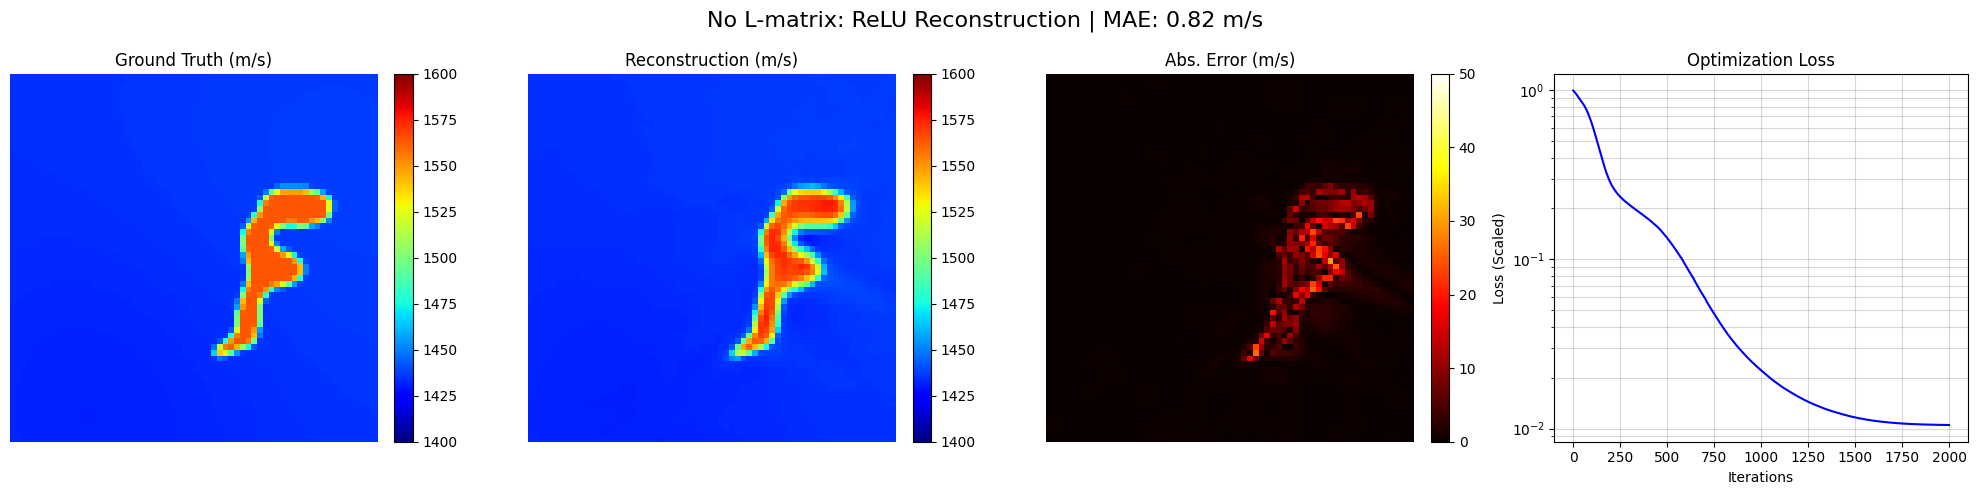

In [33]:
# 1. Experiment B: ReLU
print("\n=== Running ReLU Experiment ===")

CONFIG["model_type"] = "ReLUMLP"

model_relu_1 = ReluMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"]
)
result_relu_1 = reconstruct1(sample, model_relu_1, CONFIG["model_type"], CONFIG, use_wandb=True)
plot_results(result_relu_1, sample, title="No L-matrix: ReLU Reconstruction")
v_relu_1 = 1.0 / (result_relu_1['s_phys'].view(64, 64).numpy() + 1e-12)
#results['relu_1'] = v_relu_1

=== Running SIREN Experiment ===


Loss: 4.4466e-06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 322.11it/s]


Learning Rate,█████▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
MSE Loss,█▇▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reg Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
MSE Loss,0.0
Reg Loss,0
Total Loss,0.0


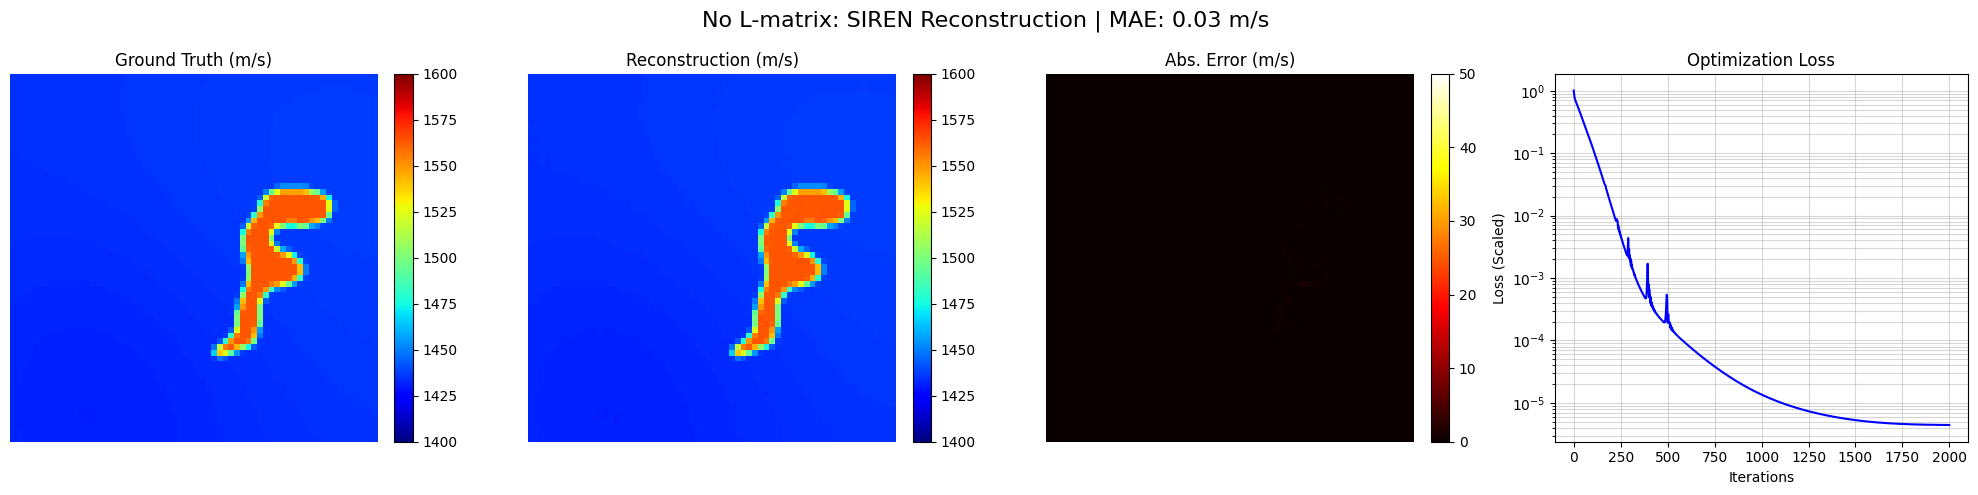

In [34]:
# 2. Experiment A: SIREN
print("=== Running SIREN Experiment ===")

CONFIG["model_type"] = "SirenMLP"

model_siren_1 = SIRENMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    omega_0 = CONFIG["omega"]
)
result_siren_1 = reconstruct1(sample, model_siren_1, CONFIG["model_type"], CONFIG, use_wandb=True)
plot_results(result_siren_1, sample, title="No L-matrix: SIREN Reconstruction")
v_siren_1 = 1.0 / (result_siren_1['s_phys'].view(64, 64).numpy() + 1e-12)
#results["siren_1"] = v_siren_1 

=== Running FourierMLP Experiment ===


Loss: 2.6771e-14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 454.54it/s]


Learning Rate,██████████▇▇▇▆▆▆▆▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
MSE Loss,█▅▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reg Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,██▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0
MSE Loss,0.0
Reg Loss,0
Total Loss,0.0


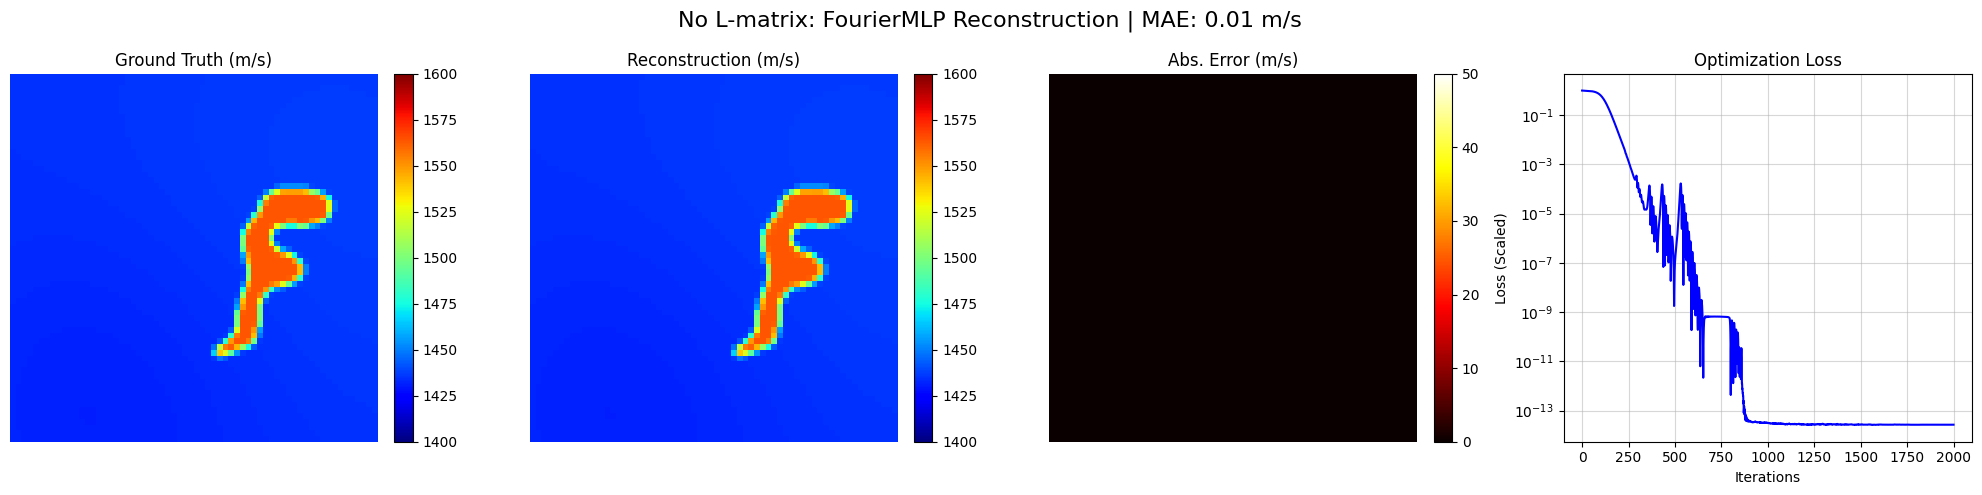

In [35]:
# 2. Experiment C: FourierMLP
print("=== Running FourierMLP Experiment ===")

CONFIG["model_type"] = "FourierMLP"

model_fourier_1 = FourierMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    scale=CONFIG["scale"]
)
result_fourier_1 = reconstruct1(sample, model_fourier_1, CONFIG["model_type"], CONFIG, use_wandb=True)
plot_results(result_fourier_1, sample, title="No L-matrix: FourierMLP Reconstruction")
v_fourier_1 = 1.0 / (result_fourier_1['s_phys'].view(64, 64).numpy() + 1e-12)
#results["fourier_1"] = v_fourier_1

### reconstructing the ground truth (sos) with full L-martix

In [65]:
def reconstruct2(sample, L_matrix, model, label="Model", config=CONFIG, use_wandb = False):
    """
    Performs the Physics-Informed reconstruction of Speed-of-Sound.
    
    Args:
        sample (dict): Single item from USDataset.
        L_matrix (Tensor): Physical L-matrix (131072, 4096).
        model (nn.Module): The initialized INR network (SIREN or ReLU).
        config (dict): Training parameters (lr, steps, etc).
        
    Returns:
        dict: containing 's_phys' (reconstruction), 'loss_history', etc.
    """

    # --- 0. Configure wandb ---
    if use_wandb:
        wandb.init(
            project=config.get("project_name"),
            group=config.get("experiment_group"),
            name=f"{label}-Sample_{config.get('sample_idx')}",
            config=config,
            reinit=True 
        )
    
    # --- 1. Device & Data Setup ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Inputs: Normalized Coordinates [-1, 1]
    coords = sample['coords'].to(device)  # (4096, 2)
    
    # Targets: Physical Measurements (Seconds)
    d_meas = sample['d_meas'].to(device)  # (131072, 1)
    mask   = sample['mask'].to(device)    # (131072, 1)
    
    # Statistics for the Translation Layer (Unpacking from dataset)
    # These convert Normalized Net Output -> Physical Slowness
    # Note: If batch size is 1, these might be single values or 1-element tensors
    s_mean = sample['s_stats'][0].to(device).item()
    s_std  = sample['s_stats'][1].to(device).item()
    
    # Matrix: Physical Units
    L = L_matrix.to(device)

    # --- 2. Optimizer Setup ---
    lr = config.get('lr', 1e-4)
    steps = config.get('steps', 2000)
    time_scale = config.get('time_scale', 1e6)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=steps)
    
    loss_history = []
    
    # --- 3. Optimization Loop ---
    pbar = tqdm(range(steps))
    
    for step in pbar:
        optimizer.zero_grad()
        
        # A. Network Forward (Normalized Space)
        # Output is roughly N(0, 1)
        s_norm = model(coords)
        
        # B. Translation Layer (Normalized -> Physical)
        # Maps unitless output to physical slowness (~0.0006 s/m)
        s_phys = s_norm * s_std + s_mean
        
        # C. Physics Forward (Physical Space)
        # d_pred = L * s_phys (Result is in Seconds ~1e-6)
        d_pred_seconds = L @ s_phys
        
        # D. Loss Calculation (Scaled Space)
        # We optimize in Microseconds to keep gradients healthy (O(1))
        residual_seconds = (d_pred_seconds - d_meas) * mask
        
        # MSE in Microseconds
        loss = ((residual_seconds * time_scale) ** 2).sum() / (mask.sum() + 1e-8)
        
        # E. Regularization (Optional)
        reg_loss = 0
        if config.get('reg_weight', 0.0) > 0:
            reg_loss += config["reg_weight"] * (s_norm ** 2).mean()

        if config.get('tv_weight', 0.0) > 0 :
            s_img = s_phys.reshape(64,64)
            tv_x = ((s_img[:, 1:] - s_img[:, :-1]) ** 2).mean()
            tv_z = ((s_img[1:, :] - s_img[:-1, :]) ** 2).mean()
            reg_loss += config['tv_weight']* (tv_x + tv_z)
                  
        total_loss = loss + reg_loss
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if step % 50 == 0:
            pbar.set_description(f"Loss (us^2): {loss.item():.4f}")

        if use_wandb:
            wandb.log({
                "Total Loss": total_loss.item(),
                "MSE Loss": loss.item(),
                "Reg Loss": reg_loss,
                "Learning Rate": scheduler.get_last_lr()[0]
            }, step=step)

    if use_wandb:
        wandb.finish()

    # --- 4. Final Processing ---
    return {
        's_phys': s_phys.detach().cpu(),
        's_norm': s_norm.detach().cpu(),
        'loss_history': loss_history,
        'model_state': model.state_dict()
    }

In [66]:
CONFIG["experiment_group"] = "Full-Matrix-Physics"

Loss (us^2): 0.0000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.75it/s]


Learning Rate,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
MSE Loss,██▇▇▆▅▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reg Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,██▇▇▅▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0
MSE Loss,4e-05
Reg Loss,0
Total Loss,4e-05


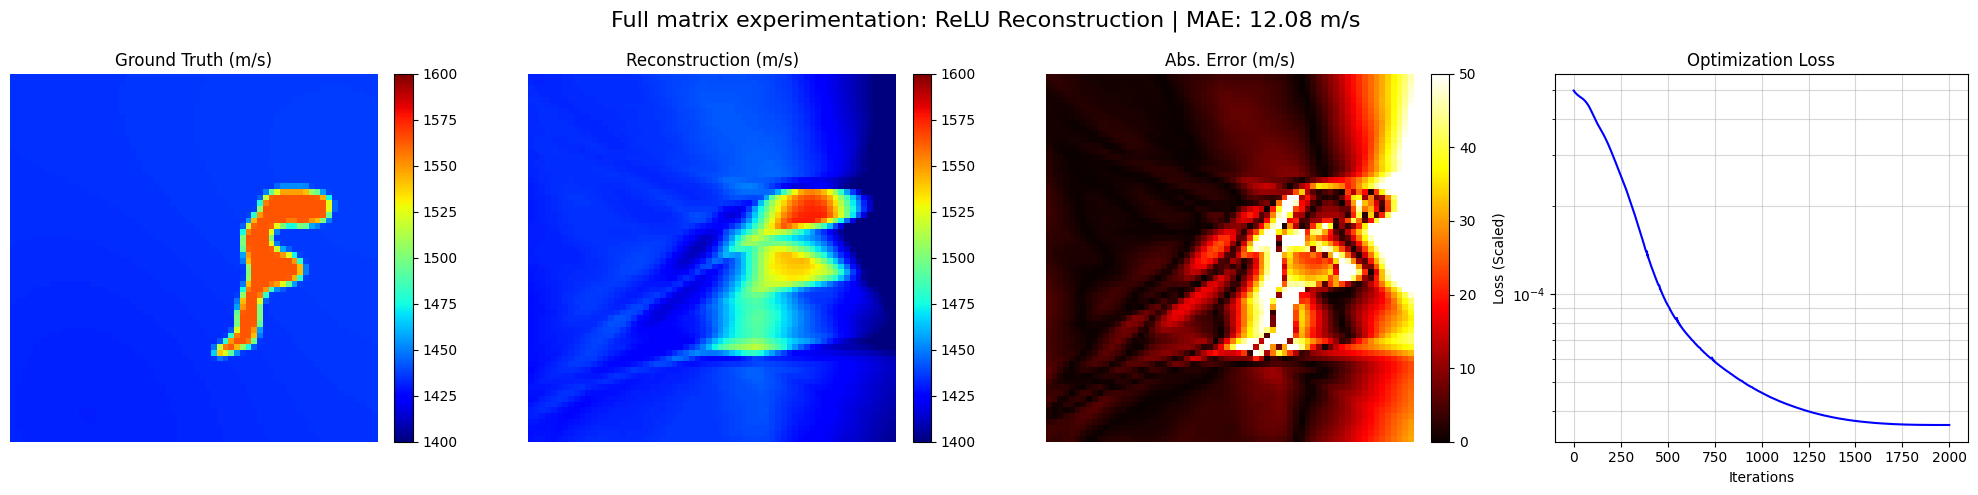

In [67]:
# 1. Experiment A: ReLU

CONFIG["model_type"] = "ReLUMLP"

model_relu_2 = ReluMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"]
)
result_relu_2 = reconstruct2(sample, l_matrix, model_relu_2, CONFIG["model_type"], CONFIG, use_wandb=True)
plot_results(result_relu_2, sample, title="Full matrix experimentation: ReLU Reconstruction")
v_relu_2 = 1.0 / (result_relu_2['s_phys'].view(64, 64).numpy() + 1e-12)
results['relu_2'] = v_relu_2

Loss (us^2): 0.0000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.23it/s]


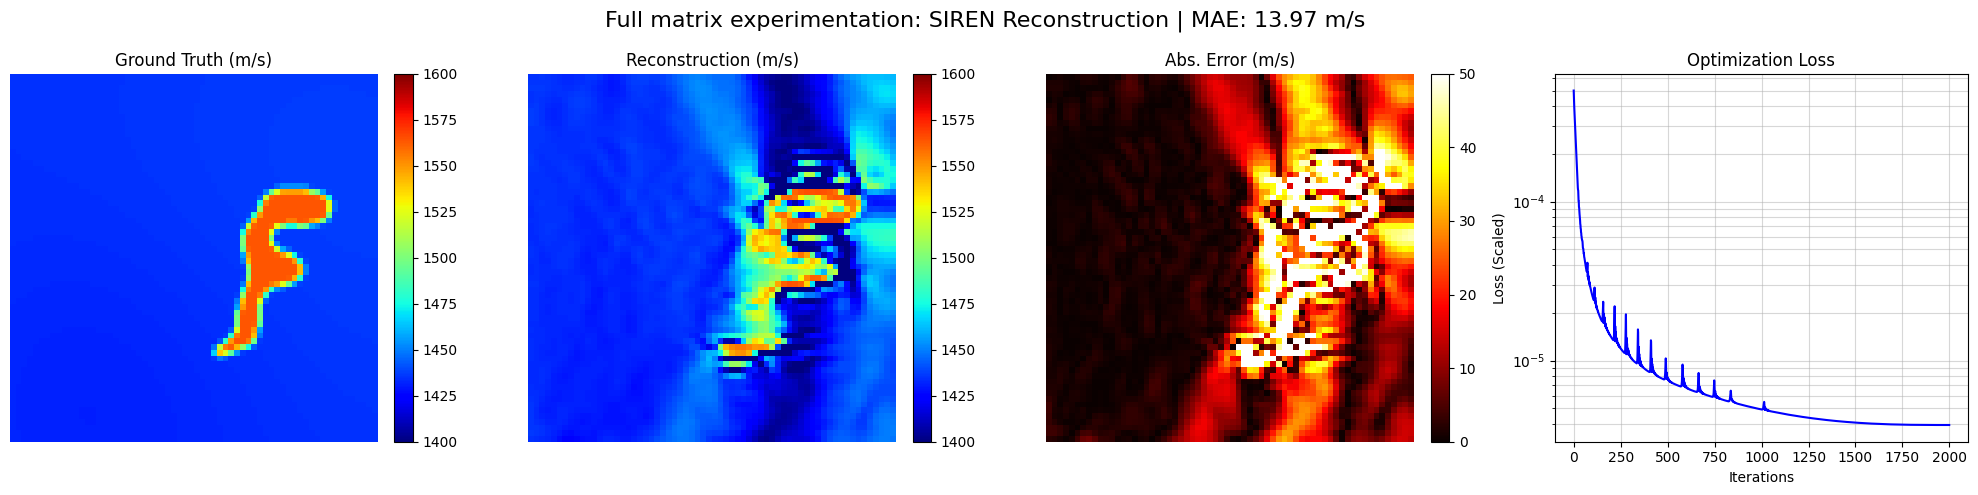

In [68]:
# 2. Experiment B: SIREN

CONFIG["model_type"] = "SirenMLP"

model_siren_2 = SIRENMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    omega_0 = CONFIG["omega"]
)
result_siren_2 = reconstruct2(sample, l_matrix, model_siren_2, CONFIG["model_type"], CONFIG)
plot_results(result_siren_2, sample, title="Full matrix experimentation: SIREN Reconstruction")
v_siren_2 = 1.0 / (result_siren_2['s_phys'].view(64, 64).numpy() + 1e-12)
results['siren_2'] = v_siren_2

Loss (us^2): 0.0000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 66.51it/s]


Learning Rate,████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
MSE Loss,█▆▆▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reg Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0
MSE Loss,1e-05
Reg Loss,0
Total Loss,1e-05


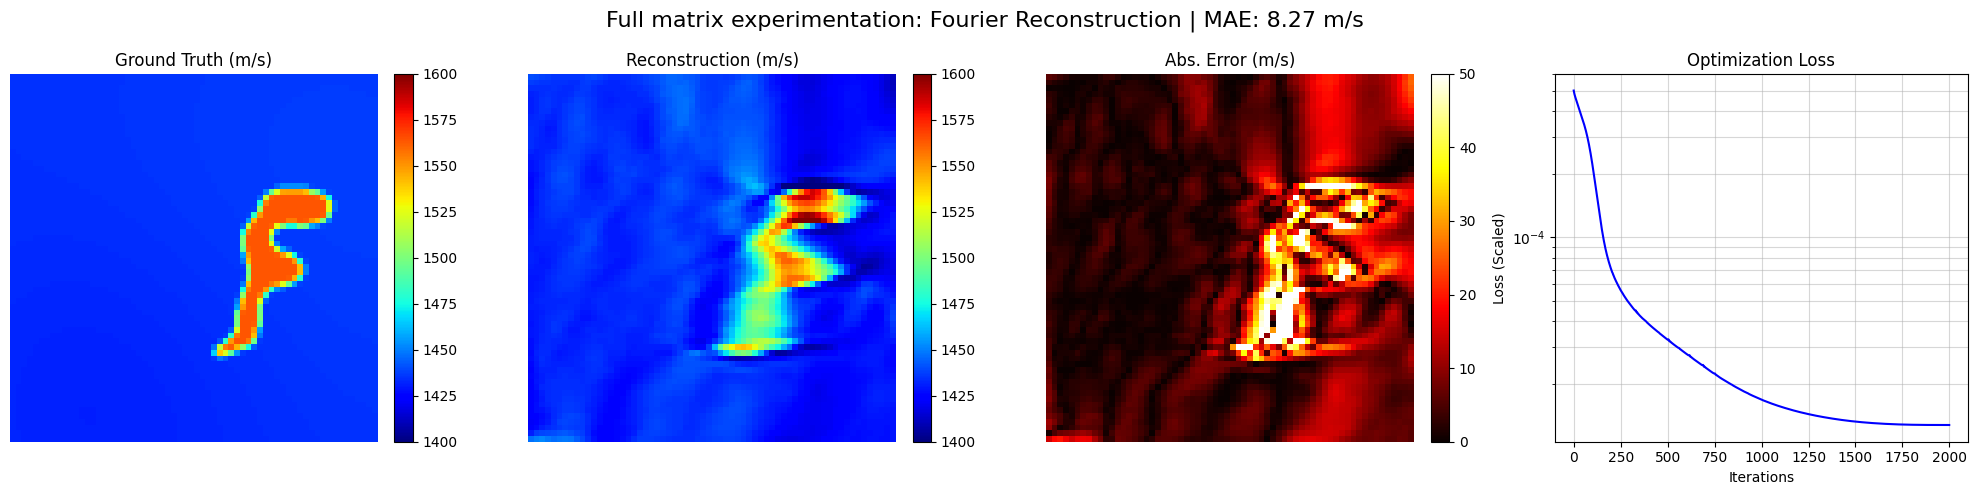

In [79]:
# 3. Experiment C: Fourier 

CONFIG["model_type"] = "FourierMLP"

model_fourier_2 = FourierMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    scale = CONFIG["scale"]
)

result_fourier_2 = reconstruct2(sample, l_matrix, model_fourier_2, CONFIG["model_type"], CONFIG,use_wandb=True)

plot_results(result_fourier_2, sample, title="Full matrix experimentation: Fourier Reconstruction")

v_relu_fourier_2 = 1.0 / (result_fourier_2['s_phys'].view(64, 64).numpy() + 1e-12)
results['relu_fourier_2'] = v_relu_fourier_2

###  reconstructing the ground truth (sos) with path-by-path (SGD)

In [83]:
def reconstruct3(sample, L_matrix, model, label="Model", config=CONFIG, use_wandb=False):
    """
    Phase 2b: Pair-by-pair reconstruction.
    Cycles through 8 pairs per outer step.
    """
    print(f"\n--- Phase 2b: Training {label} (Pair-by-Pair) on {DEVICE} ---")
    # --- 0. Configure wandb ---
    if use_wandb:
        wandb.init(
            project=config.get("project_name"),
            group=config.get("experiment_group"),
            name=f"{label}-Sample_{config.get('sample_idx')}",
            config=config,
            reinit=True 
        )
        
    # --- 1. Device & Data Setup ---
    model = model.to(DEVICE)
    
    coords   = sample['coords'].to(DEVICE)
    d_meas   = sample['d_meas'].to(DEVICE)
    mask     = sample['mask'].to(DEVICE)
    s_gt_raw = sample['s_gt_raw'].to(DEVICE)
    
    s_mean = sample['s_stats'][0].to(DEVICE).item()
    s_std  = sample['s_stats'][1].to(DEVICE).item()
    
    L = L_matrix.to(DEVICE)
    
    # --- 2. Split Into Pairs ---
    n_pairs = 8
    pair_size = L.shape[0] // n_pairs
    
    L_pairs = [L[k*pair_size:(k+1)*pair_size, :] for k in range(n_pairs)]
    d_pairs = [d_meas[k*pair_size:(k+1)*pair_size] for k in range(n_pairs)]
    m_pairs = [mask[k*pair_size:(k+1)*pair_size] for k in range(n_pairs)]
    
    #for k in range(n_pairs):
        #print(f"  Pair {k+1}: valid={m_pairs[k].sum().item():.0f} ({100*m_pairs[k].mean().item():.1f}%)")
    
    # --- 3. Optimizer Setup ---
    lr = config.get('lr', 1e-4)
    steps = config.get('steps', 2000)
    time_scale = config.get('time_scale', 1e6)
   
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=steps * n_pairs, eta_min=1e-6
    )
    
    loss_history = []
    
    # --- 4. Optimization Loop ---
    pbar = tqdm(range(steps))
    
    for step in pbar:
        step_pair_losses = []
        pair_order = torch.randperm(n_pairs).tolist()
        for k in  pair_order:
            optimizer.zero_grad()
            
            # A. Network Forward (Normalized Space)
            s_norm = model(coords)
            
            # B. Translation Layer (Normalized -> Physical)
            s_phys = s_norm * s_std + s_mean
            
            # C. Physics Forward for pair k
            d_pred_k = L_pairs[k] @ s_phys
            
            # D. Loss (Scaled to Microseconds)
            residual_k = (d_pred_k - d_pairs[k]) * m_pairs[k]
            loss_k = ((residual_k * time_scale) ** 2).sum() / (m_pairs[k].sum() + 1e-8)
            
            # E. Regularization
            reg_loss = 0
            if config.get('reg_weight', 0.0) > 0:
                reg_loss = reg_weight * (s_norm ** 2).mean()

            if config.get('tv_weight', 0.0) > 0 :
                s_img = s_phys.reshape(64,64)
                tv_x = torch.abs(s_img[:, 1:] - s_img[:, :-1]).mean()
                tv_z = torch.abs(s_img[1:, :] - s_img[:-1, :]).mean()
                reg_loss += config['tv_weight'] * (tv_x + tv_z)
              
            total_loss = loss_k + reg_loss
            
            total_loss.backward()
            optimizer.step()
            #scheduler.step()
            step_pair_losses.append(loss_k.item())
            
        scheduler.step()
        avg_loss = np.mean(step_pair_losses)
        loss_history.append(avg_loss)
        
        if step % 50 == 0:
            pbar.set_description(f"Loss (us^2): {avg_loss:.4f}")

        if use_wandb:
            wandb.log({
                "Total Loss": total_loss.item(),
                "MSE Loss": avg_loss.item(),
                "Reg Loss": reg_loss,
                "Learning Rate": scheduler.get_last_lr()[0]
            }, step=step)

    
    # --- 5. Final Processing ---
    model.eval()
    with torch.no_grad():
        s_norm = model(coords)
        s_phys = s_norm * s_std + s_mean

    if use_wandb:
        wandb.finish()
        
    return {
        's_phys': s_phys.detach().cpu(),
        's_norm': s_norm.detach().cpu(),
        'loss_history': loss_history,
        'pair_losses': [[] for _ in range(n_pairs)],  # can track if needed
        'model_state': model.state_dict()
    }

In [81]:
CONFIG["experiment_group"] = "SGD-Physics"


--- Phase 2b: Training ReLUMLP (Pair-by-Pair) on cuda ---


Loss (us^2): 0.0000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:58<00:00, 34.39it/s]


Learning Rate,██████████████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▃▃▃▃▃▂▂▂▁
MSE Loss,█▆▆▆▅▄▄▄▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reg Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▃▂▂▂▃▁▂▂▂▁▁▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0001
MSE Loss,1e-05
Reg Loss,0
Total Loss,1e-05


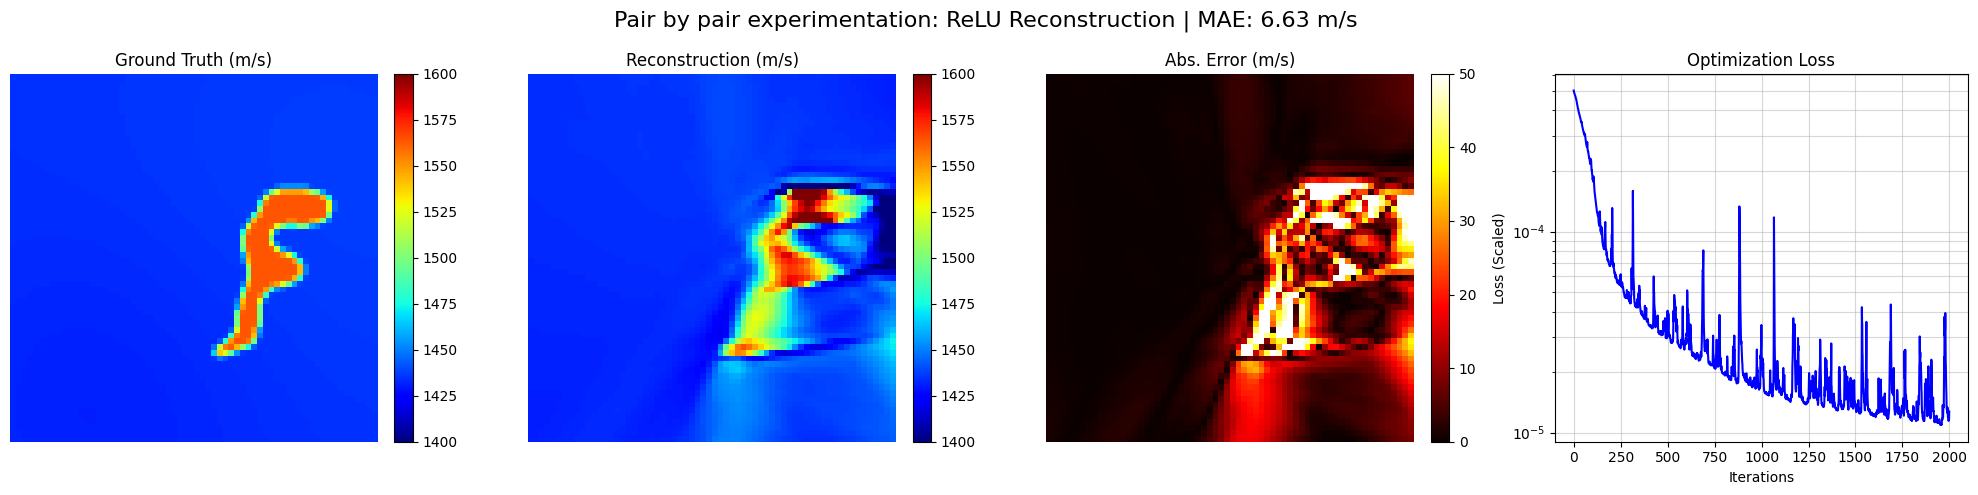

In [84]:
# 1. Experiment B: ReLU

CONFIG["model_type"] = "ReLUMLP"

model_relu_3 = ReluMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"]
)
result_relu_3 = reconstruct3(sample, l_matrix, model_relu_3,CONFIG["model_type"], config=CONFIG, use_wandb=True)
plot_results(result_relu_3, sample, title="Pair by pair experimentation: ReLU Reconstruction")
v_relu_3 = 1.0 / (result_relu_3['s_phys'].view(64, 64).numpy() + 1e-12)
results['relu_3'] = v_relu_3


--- Phase 2b: Training SirenMLP (Pair-by-Pair) on cuda ---


Loss (us^2): 0.0000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 46.71it/s]


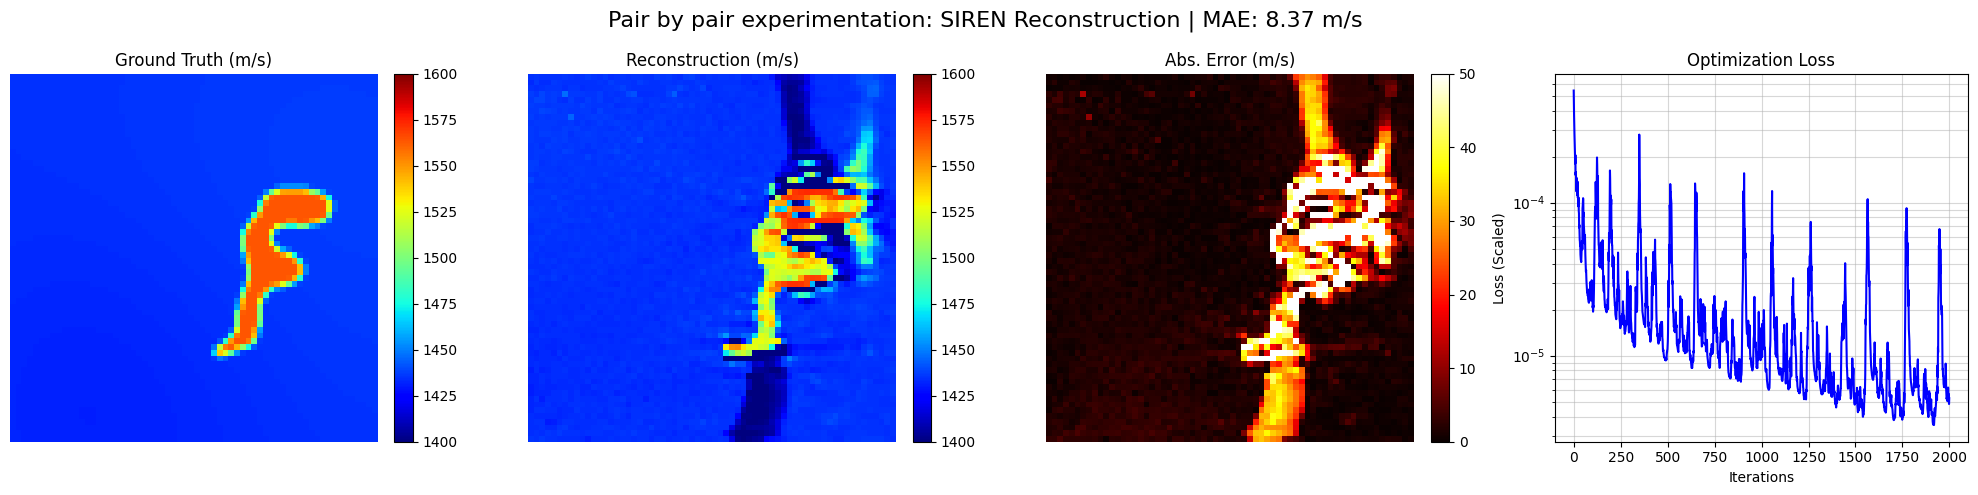

In [49]:
# 2. Experiment A: SIREN

CONFIG["model_type"] = "SirenMLP"

model_siren_3 = SIRENMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    omega_0 = CONFIG["omega"]
)
result_siren_3 = reconstruct3(sample, l_matrix, model_siren_3, CONFIG["model_type"], CONFIG, use_wandb=False)
plot_results(result_siren_3, sample, title="Pair by pair experimentation: SIREN Reconstruction")
v_siren_3 = 1.0 / (result_siren_3['s_phys'].view(64, 64).numpy() + 1e-12)
results['siren_3'] = v_siren_3


--- Phase 2b: Training FourierMLP (Pair-by-Pair) on cuda ---


Loss (us^2): 0.0000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:54<00:00, 36.89it/s]


Learning Rate,██████████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▁▁▁▁
MSE Loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Reg Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▅▆▄▄▃▃▃▂▂▂▂▂▁▁▂▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0.0001
MSE Loss,0.0
Reg Loss,0
Total Loss,0.0


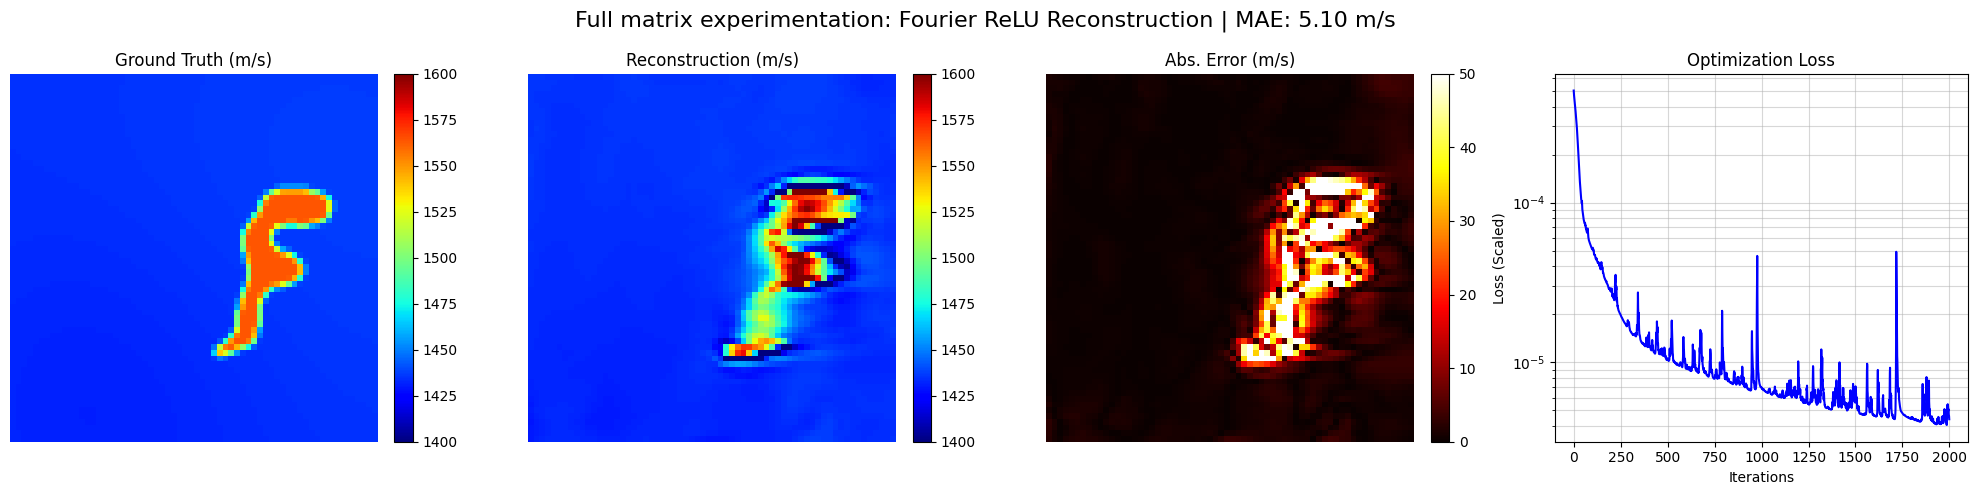

In [85]:
# 3. Experiment C: Fourier 

CONFIG["model_type"] = "FourierMLP"

model_fourier_3 = FourierMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    scale = CONFIG["scale"]
)

result_fourier_3 = reconstruct3(sample, l_matrix, model_fourier_3, CONFIG["model_type"], CONFIG,use_wandb=True)

plot_results(result_fourier_3, sample, title="Full matrix experimentation: Fourier ReLU Reconstruction")

v_relu_fourier_3 = 1.0 / (result_fourier_3['s_phys'].view(64, 64).numpy() + 1e-12)
results['relu_fourier_3'] = v_relu_fourier_3

###  reconstructing the ground truth (sos) with path-by-path ( batch)

In [59]:
# this is too slow, thus need to figure out how to make the dataloader faster
def reconstruct_no_optimal(sample, L_matrix, model, label="Model", config=CONFIG, use_wandb=False):
    logging.info(f"\n--- Training {label} (Ray-Batching) on {DEVICE} ---")
    
    # --- 0. Initialize Weights & Biases ---
    if use_wandb:
        wandb.init(
            project="INR-SoS-Recon",
            name=f"{label}-Sample{config['sample_idx']}",
            config=config,
            reinit=True
        )
        
    # --- 1. Device & Data Setup ---
    model = model.to(DEVICE)
    coords   = sample['coords'].to(DEVICE)
    
    s_mean = sample['s_stats'][0].to(DEVICE).item()
    s_std  = sample['s_stats'][1].to(DEVICE).item()

    # --- 2. Dataloader Setup ---
    ray_dataset = RayDataset(
        L_matrix = L_matrix,
        displacement_filed=sample['d_meas'],
        mask=sample['mask']
    )

    batch_size = config.get('batch_size', 4096)
    ray_loader = DataLoader(
        ray_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        pin_memory=True if DEVICE.type == 'cuda' else False,
        drop_last=False
    )

    # --- 3. Optimizer Setup ---
    epochs = config.get('epochs', 150)
    total_steps = epochs * len(ray_loader)    
    time_scale = config.get('time_scale', 1e6)

    optimizer = optim.Adam(model.parameters(), lr=config.get('lr', 1e-4))
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=total_steps, eta_min=1e-6
    )

    loss_history = []

    # --- 4. Optimization Loop ---
    pbar = tqdm(range(epochs), desc="Epochs")
    time_scale = config.get('time_scale', 1e6)
    for epoch in pbar:
        epoch_loss = 0.0
        optimizer.zero_grad()

        for batch in ray_loader:
            # only current batches
            L_batch = batch['L_row'].to(DEVICE)
            d_batch = batch['displacement'].to(DEVICE)
            m_batch = batch['mask'].to(DEVICE) 
            
            s_norm = model(coords)
            s_phys = s_norm * s_std + s_mean
            
            # (Batch_size, 4096) @ (4096, 1) -> (Batch_size, 1)
            d_pred_batch = L_batch @ s_phys

            residual = (d_pred_batch - d_batch) * m_batch
            loss_data = ((residual * time_scale) ** 2).sum() / (m_batch.sum() + 1e-8)
            reg_loss = 0.0
            if config.get('reg_weight', 0.0) > 0:
                reg_loss = config['reg_weight'] * (s_norm ** 2).mean()

            if config.get('tv_weight', 0.0) > 0:
                s_img = s_phys.reshape(64, 64)
                tv_x = torch.abs(s_img[:, 1:] - s_img[:, :-1]).mean()
                tv_z = torch.abs(s_img[1:, :] - s_img[:-1, :]).mean()
                reg_loss += config['tv_weight'] * (tv_x + tv_z)
        
        total_loss = loss_data + reg_loss
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss_data.item()

    # --- 5. Epoch-Level Logging ---
    avg_epoch_loss = epoch_loss / len(ray_loader)
    loss_history.append(avg_epoch_loss)
    
    if use_wandb:
            wandb.log({
                "Epoch": epoch,
                "Avg Epoch Data Loss": avg_epoch_loss,
                "Learning Rate": scheduler.get_last_lr()[0]
            })
        
    if epoch % config.get('log_interval', 10) == 0:
            pbar.set_description(f"Avg Loss (us^2): {avg_epoch_loss:.4f}")

    if use_wandb:
        wandb.finish()

    # --- 6. Final Processing ---
    model.eval()
    with torch.no_grad():
        s_norm = model(coords)
        s_phys = s_norm * s_std + s_mean

    return {
        's_phys': s_phys.detach().cpu(),
        's_norm': s_norm.detach().cpu(),
        'loss_history': loss_history,
        'model_state': model.state_dict()
    }    

In [5]:
def reconstruct4(sample, L_matrix, model, label="Model", config=None, use_wandb=False):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n--- Phase 2c: Training {label} (Fast GPU Slicing) on {DEVICE} ---")
    
    # --- 0. Configure wandb ---
    if use_wandb:
        wandb.init(
            project=config.get("project_name"),
            group=config.get("experiment_group"),
            name=f"{label}-Sample_{config.get('sample_idx')}",
            config=config,
            reinit=True 
        )
    
    model = model.to(DEVICE)
    coords = sample['coords'].to(DEVICE)
    
    s_mean = sample['s_stats'][0].item()
    s_std  = sample['s_stats'][1].item()
    
    L = L_matrix.to(DEVICE)             # 2.14 GB
    d_meas = sample['d_meas'].to(DEVICE)
    mask = sample['mask'].to(DEVICE)
    
    total_rays = L.shape[0]
    batch_size = config.get('batch_size', 4096)
    epochs = config.get('epochs', 150)
    
    # Calculate steps exactly as before
    steps_per_epoch = int(np.ceil(total_rays / batch_size))
    total_steps = epochs * steps_per_epoch
    
    optimizer = optim.Adam(model.parameters(), lr=config.get('lr', 1e-4))
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)
    
    loss_history = []
    pbar = tqdm(range(epochs), desc="Epochs")
    time_scale = config.get('time_scale', 1e6)
    
    for epoch in pbar:
        epoch_loss = 0.0
        
        # 1. SHUFFLE THE DECK ON THE GPU
        # This gives us a random sequence of indices [0, 131071] with NO replacements
        permuted_indices = torch.randperm(total_rays, device=DEVICE)
        
        # 2. SLICE INTO BATCHES
        for step in range(steps_per_epoch):
            optimizer.zero_grad()
            
            # Get the index range for this batch
            start_idx = step * batch_size
            end_idx = min(start_idx + batch_size, total_rays)
            
            # Grab the random indices for this batch
            batch_idx = permuted_indices[start_idx:end_idx]
            
            # INSTANT GPU SLICING (No DataLoader overhead!)
            L_batch = L[batch_idx]
            d_batch = d_meas[batch_idx]
            m_batch = mask[batch_idx]
            
            # --- Network Forward & Physics ---
            s_norm = model(coords)
            s_phys = s_norm * s_std + s_mean
            
            d_pred_batch = L_batch @ s_phys
            
            # --- Loss ---
            residual = (d_pred_batch - d_batch) * m_batch
            loss_data = ((residual * time_scale) ** 2).sum() / (m_batch.sum() + 1e-8)
            
            # --- Regularization ---
            reg_loss = 0
            if config.get('reg_weight', 0.0) > 0:
                reg_loss = config['reg_weight'] * (s_norm ** 2).mean()

            if config.get('tv_weight', 0.0) > 0:
                s_img = s_phys.reshape(64, 64)
                tv_x = torch.abs(s_img[:, 1:] - s_img[:, :-1]).mean()
                tv_z = torch.abs(s_img[1:, :] - s_img[:-1, :]).mean()
                reg_loss += config['tv_weight'] * (tv_x + tv_z)
                
            total_loss = loss_data + reg_loss
            
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss_data.item()
            
        # --- Epoch-Level Logging ---
        avg_epoch_loss = epoch_loss / steps_per_epoch
        loss_history.append(avg_epoch_loss)
        
        if use_wandb:
            wandb.log({
                "Epoch": epoch,
                "Avg Epoch Data Loss": avg_epoch_loss,
                "Learning Rate": scheduler.get_last_lr()[0]
            })
            
        if epoch % config.get('log_interval', 10) == 0:
            pbar.set_description(f"Avg Loss (us^2): {avg_epoch_loss:.4f}")

    if use_wandb:
        wandb.finish()
            
    model.eval()
    with torch.no_grad():
        s_norm = model(coords)
        s_phys = s_norm * s_std + s_mean
    
    return {
        's_phys': s_phys.detach().cpu(),
        's_norm': s_norm.detach().cpu(),
        'loss_history': loss_history,
        'model_state': model.state_dict()
    }

In [6]:
CONFIG["experiment_group"] = 'Ray-Batching'


--- Phase 2c: Training ReLUMLP (Fast GPU Slicing) on cuda ---


Avg Loss (us^2): 0.0000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [14:42<00:00,  2.27it/s]


Avg Epoch Data Loss,█▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Learning Rate,█████████▇▇▇▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁
Avg Epoch Data Loss,0.0
Epoch,1999
Learning Rate,0.0


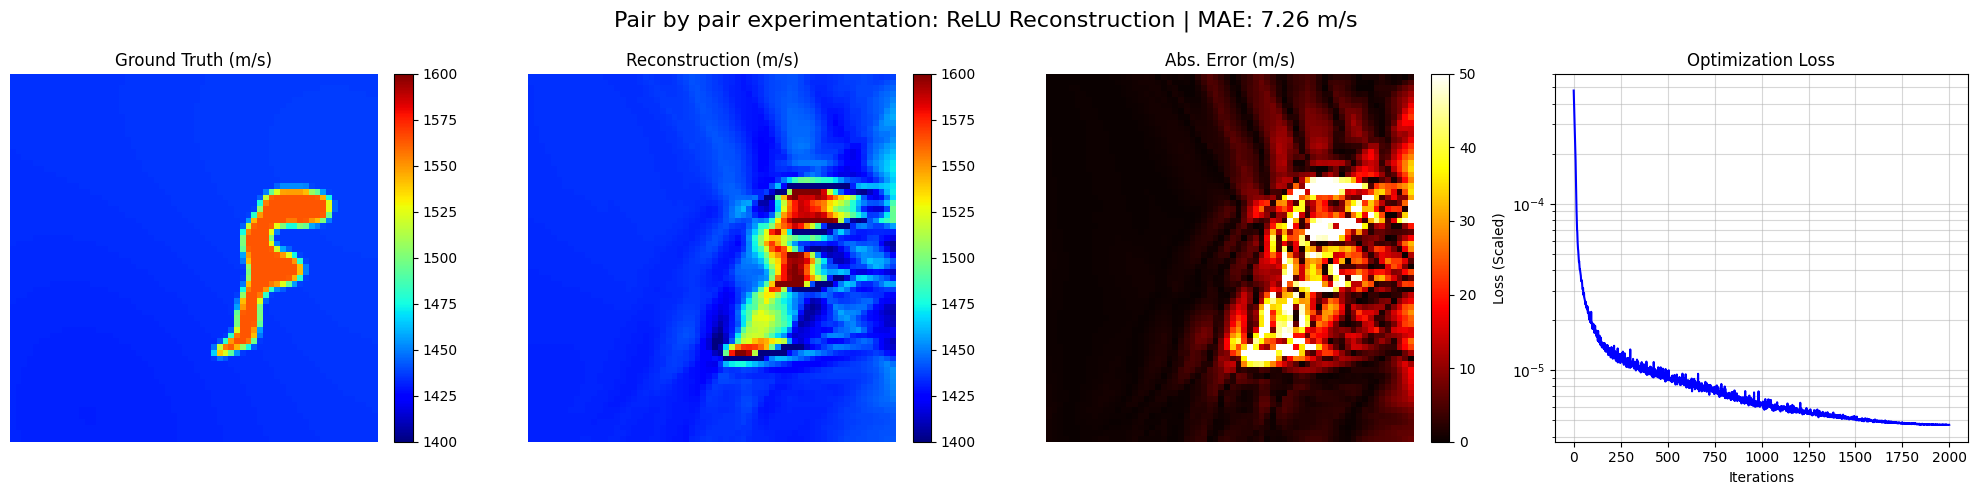

In [88]:
# 1. Experiment A: ReLU

CONFIG["model_type"] = "ReLUMLP"

model_relu_4 = ReluMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"]
)

result_relu_4 = reconstruct4(sample, l_matrix, model_relu_4,CONFIG["model_type"], config=CONFIG, use_wandb=True)
v_relu_4 = 1.0 / (result_relu_4['s_phys'].view(64, 64).numpy() + 1e-12)
plot_results(result_relu_4, sample, title="Pair by pair experimentation: ReLU Reconstruction")
results['relu_4'] = v_relu_4

In [ ]:
# 2. Experiment A: SIREN

CONFIG["model_type"] = "SirenMLP"

model_siren_4 = SIRENMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    omega_0 = CONFIG["omega"]
)
result_siren_4 = reconstruct4(sample, l_matrix, model_siren_4, CONFIG["model_type"], CONFIG, use_wandb=False)
plot_results(result_siren_4, sample, title="Pair by pair experimentation: SIREN Reconstruction")
v_siren_4 = 1.0 / (result_siren_4['s_phys'].view(64, 64).numpy() + 1e-12)
results['siren_4'] = v_siren_4


--- Phase 2c: Training FourierMLP (Fast GPU Slicing) on cuda ---


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/haben/.netrc.
wandb: Currently logged in as: habenhadush (habenhadush-uppsala-universitet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Avg Loss (us^2): 0.0000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:41<00:00,  2.44it/s]


Avg Epoch Data Loss,█▇▆▅▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇███
Learning Rate,███████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Avg Epoch Data Loss,0.0
Epoch,1999
Learning Rate,0.0


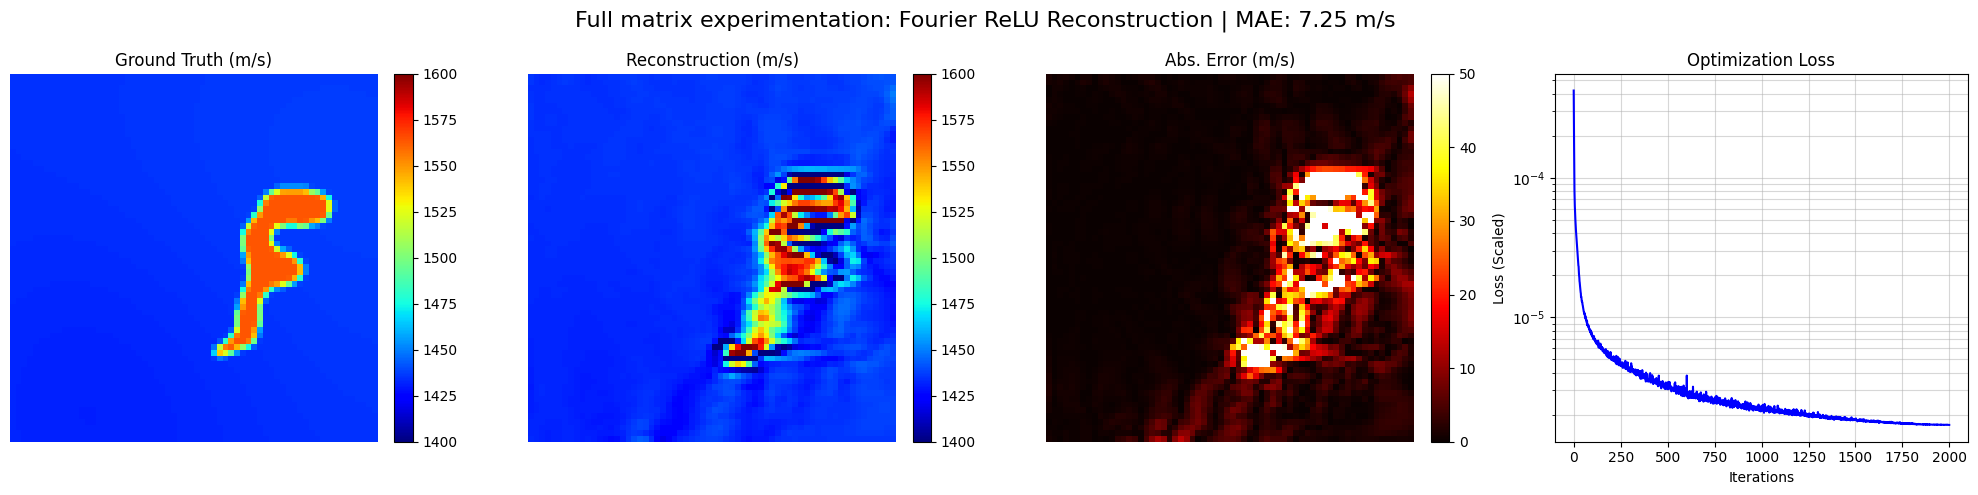

In [7]:
# 3. Experiment C: Fourier 

CONFIG["model_type"] = "FourierMLP"

model_fourier_4 = FourierMLP(
    in_features=CONFIG["in_features"], 
    hidden_features=CONFIG["hidden_features"], 
    hidden_layers=CONFIG["hidden_layers"],
    scale = CONFIG["scale"]
)

result_fourier_4 = reconstruct4(sample, l_matrix, model_fourier_4, CONFIG["model_type"], CONFIG,use_wandb=True)

plot_results(result_fourier_4, sample, title="Full matrix experimentation: Fourier ReLU Reconstruction")

v_relu_fourier_4 = 1.0 / (result_fourier_4['s_phys'].view(64, 64).numpy() + 1e-12)
results['relu_fourier_4'] = v_relu_fourier_4

INFO:root:
INFO:root:  Reconstruction Comparison |  Reconstruction | Sample 8
INFO:root:======================================================================
INFO:root:  Method                    RMSE (m/s)      MAE (m/s)       CNR       
INFO:root:  ------------------------------------------------------------
INFO:root:  L2                        22.60           9.50            0.79      
INFO:root:  L1                        16.80           6.44            0.41      
INFO:root:  relu_fourier_4            26.21           7.25            0.27      
INFO:root:  GT (reference)            0.00            0.00            0.38      
INFO:root:======================================================================


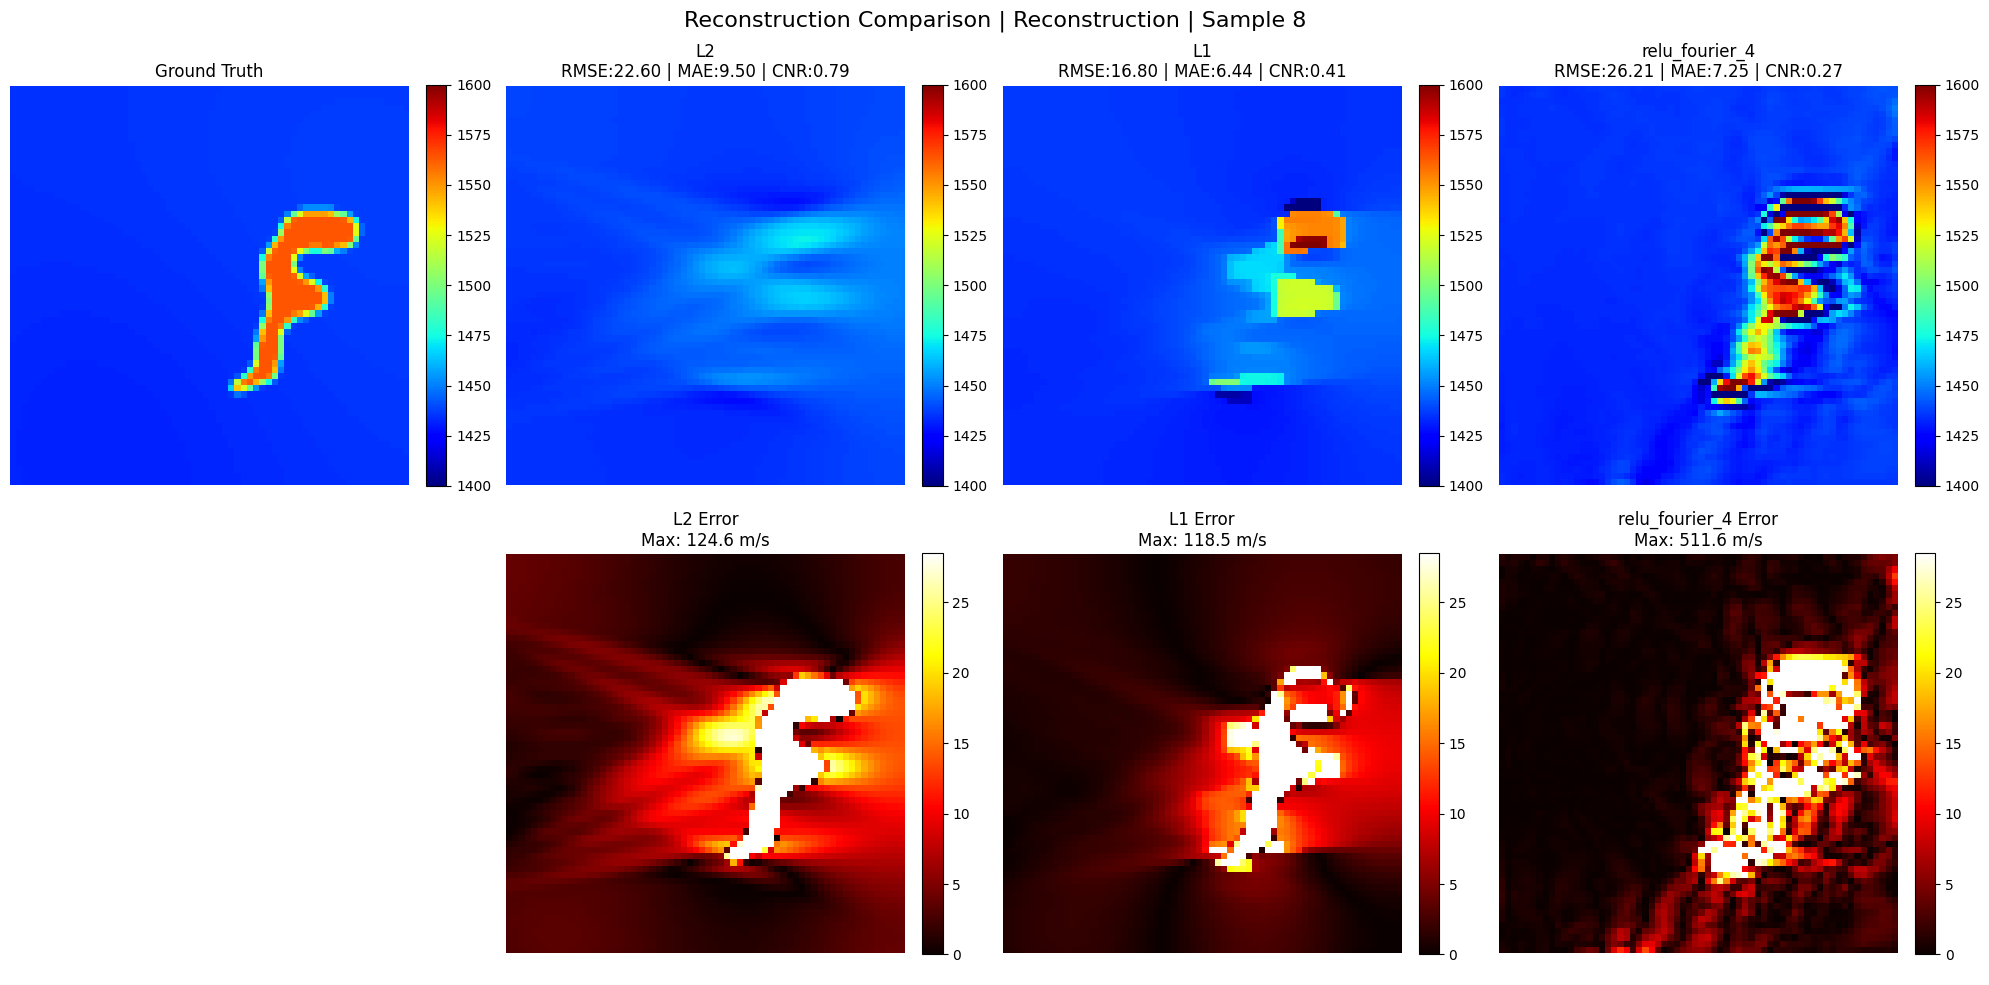

In [8]:
# Compare all
metrics = compare_reconstructions(v_gt, results, title= "Reconstruction", sample_idx=CONFIG["sample_idx"])